# Installing the dependencies, accessing Google Drive

In [ ]:
# Install necessary dependencies
!pip install fasttext --quiet
!pip install simpletransformers --quiet

     |████████████████████████████████| 71kB 5.4MB/s 
     |████████████████████████████████| 204kB 8.2MB/s 
     |████████████████████████████████| 2.9MB 24.3MB/s 
     |████████████████████████████████| 1.8MB 58.3MB/s 
     |████████████████████████████████| 51kB 9.6MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
     |████████████████████████████████| 317kB 55.7MB/s 
     |████████████████████████████████| 7.4MB 42.7MB/s 
     |████████████████████████████████| 1.4MB 62.4MB/s 
     |████████████████████████████████| 1.1MB 54.5MB/s 
     |████████████████████████████████| 133kB 67.7MB/s 
     |████████████████████████████████| 102kB 15.0MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 163kB 55.4MB/s 
     |████████████████████████████████| 4.5MB 57.4MB/s 
     |████████████████████████████████| 112kB 66.1MB/s 
     |████████████████████████████████| 890kB 49.9MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import fasttext
import csv
import os, errno
from simpletransformers.classification import ClassificationModel
from glob import glob

In [ ]:
# Mount the Google Drive
# This is necessary for accessing the generated texts
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Load the generated texts from Google Drive

In [ ]:
NUM_ARTICLES = 100
#PATH = "/content/drive/My Drive/"
PATH = "/content/drive/MyDrive/data/"

In [ ]:
def extract_articles_GPT():
  """
  A helper function to extract the articles generated with GPT2

  This function accesses the generated texts provided on Google Drive
  and extracts them into a Pandas DataFrame.
  """
  GPT_list = []
  i = 0

  for text in glob(PATH+"/Generated texts GPT/withCutoff/*.txt"):
    with open(text, 'r') as file:
      secret = file.read()
    row_dict = {'label': 1}
    row_dict.update(text = secret)
    GPT_list.append(row_dict)
    i += 1
    if i > NUM_ARTICLES:
      break
  return pd.DataFrame(data=GPT_list)

In [ ]:
def extract_articles_BERT():
  """
  A helper function to extract the articles generated with BERT

  This function accesses the generated texts provided on Google Drive
  and extracts them into a Pandas DataFrame.
  """
  BERT_list = []
  i = 0

  for text in glob(PATH+"/Generated texts BERT/*.txt"):
    with open(text, 'r') as file:
      secret = file.read()
    row_dict = {'label': 1}
    row_dict.update(text = secret)
    BERT_list.append(row_dict)
    i += 1
    if i > NUM_ARTICLES:
      break
  return pd.DataFrame(data=BERT_list)

In [ ]:
def extract_articles_ROBERTA():
  """
  A helper function to extract the cover texts generated with RoBERTa

  This function accesses the generated texts provided on Google Drive
  and extracts them into a Pandas DataFrame.
  """
  ROBERTA_list = []
  i = 0
  for text in glob(PATH+"/Generated texts RoBERTa/*.txt"):
    with open(text, 'r') as file:
      secret = file.read()
    row_dict = {'label': 1}
    row_dict.update(text = secret)
    ROBERTA_list.append(row_dict)
    i += 1
    if i > NUM_ARTICLES:
      break 
  return pd.DataFrame(data=ROBERTA_list)

In [ ]:
def extract_raw_articles():
  """
  A helper function to extract the raw articles from our testing set

  This function accesses the generated texts provided on Google Drive
  and extracts them into a Pandas DataFrame.
  """
  RAW_list = []
  i = 0
  for text in glob(PATH+"/Raw articles new/*.txt"):
    with open(text, 'r') as file:
      secret = file.read()
    row_dict = {'label': 0}
    row_dict.update(text = secret)
    RAW_list.append(row_dict)
    i += 1
    if i > NUM_ARTICLES:
      break
  return pd.DataFrame(data=RAW_list)

In [ ]:
df_GPT, df_BERT, df_ROBERTA, df_RAW = extract_articles_GPT(), extract_articles_BERT(), extract_articles_ROBERTA(), extract_raw_articles()

# fasttext

In [ ]:
def prepare_df_for_fasttext(orig_df, train_test_ratio):
  """
  A function that converts a given DataFrame into 2 .txt files for fasttext
  """

  # Copy the original DataFrame
  df = orig_df.copy()

  # Convert the 'label' column to fasttext labels
  df['label'] = df['label'].astype('str')
  df['label'] = '__label__' + df['label']

  # Split the given DataFrame into a training and testing set
  df_fasttext_train, df_fasttext_test = train_test_split(df, train_size = train_test_ratio, random_state = 1)

  # Save the training set as 'train.txt' locally
  df_fasttext_train.to_csv('train.txt', 
          index = False, 
          sep = ' ',
          header = None, 
          quoting = csv.QUOTE_NONE, 
          quotechar = "", 
  escapechar = " ")

  # Save the testing set as 'test.txt' locally
  df_fasttext_test.to_csv('test.txt', 
          index = False, 
          sep = ' ',
          header = None, 
          quoting = csv.QUOTE_NONE, 
          quotechar = "", 
  escapechar = " ")

  return

In [ ]:
# Prepare the DataFrame for fasttext, save it locally
train_test_ratio = 0.90

prepare_df_for_fasttext(pd.concat([df_RAW, df_GPT]), train_test_ratio)

In [ ]:
# Train the fasttext model
model = fasttext.train_supervised('train.txt', wordNgrams = 200) # the number of n-grams can be arbitrarily high

In [ ]:
# Evaluate the fasttext model
model.test('test.txt')

(11, 1.0, 1.0)

# Transformer-based classifier

In [ ]:
# Split the DataFrame into training/testing, sort the columns
df_t_train, df_t_test = train_test_split(pd.concat([df_RAW, df_GPT]), train_size = train_test_ratio, random_state = 1)
df_t_train = df_t_train[['text', 'label']]
df_t_test = df_t_test[['text', 'label']]

In [ ]:
# Clear the OUTPUTS directory
for root, dirs, files in os.walk('./outputs/'):
    for f in files:
        os.unlink(os.path.join(root, f))
    for d in dirs:
        os.rmdir(os.path.join(root, d))

# Create the classifier, train it and evaluate it
transformer_classifier = ClassificationModel('roberta', 'roberta-base', use_cuda=True)
transformer_classifier.train_model(df_t_train, overwrite_output_dir=True)
result, model_outputs, wrong_predictions = transformer_classifier.eval_model(df_t_test)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:387: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:966: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [ ]:
# Compute the accuracy : (TN + TP) / N 
trues = result['tn'] + result['tp']
falses = result['fn'] + result['fp']

accuracy = trues / (trues + falses)
print(accuracy)

0.9523809523809523


# LSTM

In [ ]:
# Create a 'lstm' folder if it doesn't exist
try:
  os.makedirs('lstm')
except OSError as e:
  if e.errno != errno.EEXIST:
    raise

In [ ]:
# Helper functions and variables for LSTM classification

destination_folder = './lstm/'

train_test_ratio = 0.90
train_valid_ratio = 0.80

first_n_words = 200

def trim_string(x):
    """
    A helper function that extract the first N words from an article
    """
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x

In [ ]:
# Read raw data
df_raw = pd.concat([df_RAW, df_GPT])

# Drop rows with empty text
df_raw.drop( df_raw[df_raw.text.str.len() < 5].index, inplace=True)

# Trim text and titletext to first_n_words
df_raw['text'] = df_raw['text'].apply(trim_string)

# Split according to label
df_real = df_raw[df_raw['label'] == 0]
df_fake = df_raw[df_raw['label'] == 1]

# Train-test split
df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv(destination_folder + '/train.csv', index=False)
df_valid.to_csv(destination_folder + '/valid.csv', index=False)
df_test.to_csv(destination_folder + '/test.csv', index=False)

In [ ]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preliminaries
from torchtext.data import Field, TabularDataset, BucketIterator

# Models
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('text', text_field)]

# TabularDataset
train, valid, test = TabularDataset.splits(path=destination_folder, train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators
train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=3, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary
text_field.build_vocab(train, min_freq=3)

In [ ]:
class LSTM(nn.Module):
    """
    An LSTM-based network comprised of
    an embedding layer,
    an LSTM layer
    and a FC (fully-connected) sigmoid layer
    used for text classification
    """

    def __init__(self, dimension=128):
        """
        A constructor that defines the architecture of the network.
        """
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):
      """
      A function that defines the forward-pass of the NN.
      """

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [ ]:
# Save and Load Functions
def save_checkpoint(save_path, model, optimizer, valid_loss):
  """
  A function that saves the current state of the model
  """

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):
  """
  A function that loads the saved state of the model
  """

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
  """
  A function that saves the metrics (train/val loss) of the model
  """

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):
  """
  A function that loads the metrics (train/val loss) of the model
  """

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [ ]:
# Training Function
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    """
    A function that defines the training of our LSTM model.
    """
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (text, text_len)), _ in train_loader:      
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len.cpu())

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (text, text_len)), _ in valid_loader:
                      labels = labels.to(device)
                      text = text.to(device)
                      text_len = text_len.to(device)
                      output = model(text, text_len.cpu())

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

# Load and train the model
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

torch.device('cpu')
train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [34/680], Train Loss: 0.5463, Valid Loss: 0.5789
Model saved to ==> ./lstm//model.pt
Model saved to ==> ./lstm//metrics.pt
Epoch [1/10], Step [68/680], Train Loss: 0.5735, Valid Loss: 0.5831
Epoch [2/10], Step [102/680], Train Loss: 0.4561, Valid Loss: 0.4847
Model saved to ==> ./lstm//model.pt
Model saved to ==> ./lstm//metrics.pt
Epoch [2/10], Step [136/680], Train Loss: 0.3873, Valid Loss: 0.4656
Model saved to ==> ./lstm//model.pt
Model saved to ==> ./lstm//metrics.pt
Epoch [3/10], Step [170/680], Train Loss: 0.2520, Valid Loss: 0.3249
Model saved to ==> ./lstm//model.pt
Model saved to ==> ./lstm//metrics.pt
Epoch [3/10], Step [204/680], Train Loss: 0.1826, Valid Loss: 0.4144
Epoch [4/10], Step [238/680], Train Loss: 0.1188, Valid Loss: 0.2679
Model saved to ==> ./lstm//model.pt
Model saved to ==> ./lstm//metrics.pt
Epoch [4/10], Step [272/680], Train Loss: 0.0637, Valid Loss: 0.5179
Epoch [5/10], Step [306/680], Train Loss: 0.0440, Valid Loss: 0.2547
Model saved

Model loaded from <== ./lstm//metrics.pt


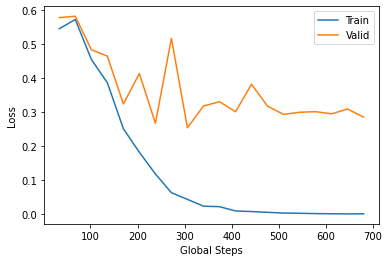

In [ ]:
# Plot the learning curves for the training and validation loss
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Model loaded from <== ./lstm//model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8780    0.7129    0.7869       101
           0     0.8682    0.9502    0.9074       201

    accuracy                         0.8709       302
   macro avg     0.8731    0.8316    0.8471       302
weighted avg     0.8715    0.8709    0.8671       302



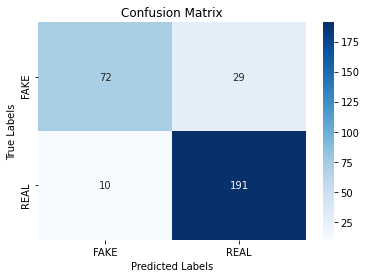

In [ ]:
# Evaluation Function
def evaluate(model, test_loader, version='title', threshold=0.5):
  """
  A function that plots a confusion matrix and outputs
  the evaluation results (accuracy, precision, recall...)
  """
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len.cpu())

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
# Load and evaluate the model
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)